# Utilizando una CNN para reconocimiento de ¿Imagen? ¡NO! ¡AUDIO!

## Reconocimiento de palabras clave

En esta notebook vamos a implementar un modelo de procesamiento de lenguaje natural para reconocimiento de palabras habladas. En este caso, se entrenará el algoritmo para entender los números del cero al nueve en español. Para esto, utilizaremos el dataset de uso libre $\textit{Common Voice}$ proporcionado gratuitamente por Mozilla. El mismo puede descargarse en [1] (no es el de ~15GB, es el de abajo). En cuánto al modelo, utilizaremos una versión customizada del propuesto por el equipo de TensorFlow [2]

El modelo implementado es una red neuronal convolucional construida en $\texttt{Keras}$ que permitió una $\textbf{accuracy del}$ $94\%$. Además, para el preprocesamiento de los datos y las visualizaciones se utilizaron las librerías $\texttt{matplotlib}$, $\texttt{seaborn}$, $\texttt{pandas}$, $\texttt{numpy}$ y $\texttt{tensorflow_io}$.

Importamos las librerías a utilizar:

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_io as tfio
import pandas as pd

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

### Definir el dataset

El siguiente paso es "levantar" el dataset a utilizar. Para esto, instanciaremos un objeto $\texttt{DataFrame}$ de Pandas a partir de un archivo en formato $\texttt{tsv}$ (tab separated values). Esto se hace de la misma manera que para los archivos de tipo $\texttt{csv}$ pero especificando en el argumento de la función el tipo de separador de los datos. 

La tabla está formada por dos columnas, una con la ubicación del archivo de audio en el directorio base y la otra con el label correspondiente al archivo. Para esto, modificamos la columna "path" para que se corresponda con la estructura de nuestro directorio. Los archivos de audio deben estar ubicados en el directorio "/datasets/es_singleword/clips/" dentro del directorio principal. Los archivos $\texttt{tsv}$ deben estar ubicados en el directorio "/datasets/es_singleword/"

Por último, organizamos los datos en un diccionario con estructura $\texttt{\{'audio':list(),'text':list()\}}$ y separamos los datos para entrenamiento, validación y prueba. Además, definimos en una lista los labels de nuestro dataset en la variable $\texttt{keywords}$:

In [2]:
df = pd.read_csv('datasets/es_singleword/validated.tsv', sep='\t', header=0, encoding='utf-8')[['path','sentence']]
df.path = df.path.apply(lambda x: 'datasets/es_singleword/clips/'+x)
df = df[~((df.sentence == 'sí')|(df.sentence == 'no')|(df.sentence == 'Hey')|(df.sentence == 'Firefox'))]
max_char_len = df.sentence.apply(lambda x: len(x)).max()

def get_data(df, maxlen=50):
    """ returns mapping of audio paths and transcription texts """
    data = [{"audio":row[1].values[0],"text":row[1].values[1]} for row in df.iterrows() if len(row[1].values[1])<= maxlen]
    return data

keywords = [word.lower().strip() for word in df.sentence.unique()]

data = get_data(df,max_char_len)
train_set = data[:int(len(data)*0.8)]
val_set = data[int(len(data)*0.8):int(len(data)*0.9)]
test_set = data[int(len(data)*0.9):]

Luego, podemos evaluar cuán balanceado está el dataset. Para esto siempre es útil un gráfico de barras que nos de una idea de si alguna etiqueta aparece considerablemente más o menos que otras. Saber esto es necesario a la hora de evaluar la performance del modelo. Si el dataset esta altamente desbalanceado, la métrica accuracy no suele ser recomendable dado que puede arrojar altos valores de exactitud y aún así esto no estar vinculado a una buena performance. En estos casos se recomiendan otro tipo de métricas como F1, Recall o Precision.

<AxesSubplot:>

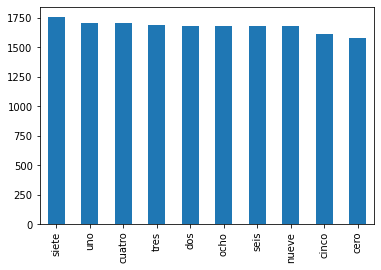

In [3]:
df.sentence.value_counts().plot(kind="bar")

Como vemos, el dataset presenta un buen balance de etiquetas. Esto ya nos anticipa que podremos usar la métrica $\textit{accuracy}$ sin problemas para evaluar la bondad del modelo.

In [4]:
len(train_set)

13406

In [5]:
keywords

['tres',
 'cinco',
 'uno',
 'nueve',
 'siete',
 'ocho',
 'cuatro',
 'dos',
 'seis',
 'cero']

### Preprocesamiento de los datos

A continuación vamos a pre-procesar y visualizar los datos para tener una mejor idea de la información que le entregaremos al modelo y cómo este lo utilizará en su aprendizaje. Para empezar, vamos a procesar los archivos de audio. Para esto utilizamos las funciones de Tensorflow $\texttt{read_file}$ y $\texttt{decode_mp3}$. La primera recibe la ubicación del archivo y devuelve un tensor con la información del archivo en binario. La segunda función decodifica el tensor binario convirtiéndolo en un tensor de números enteros. La función $\texttt{squeeze}$ simplemente traspone el tensor resultando en un vector cuyo tamaño depende de la duración del archivo de audio.

In [6]:
def decode_audio(audio_binary):
  audio = tf.io.read_file(audio_binary)
  audio = tfio.audio.decode_mp3(audio)
  return tf.squeeze(audio, axis=-1)

A continuación, con la información adquirida y procesada hasta el momento, construimos los objetos $\texttt{Dataset}$ de Tensorflow. La función $\texttt{create_waveform_dataset}$ dejará asociada la forma de onda obtenida con $\texttt{decode_audio}$ a su label correspondiente.

In [7]:
def create_text_ds(data):
    texts = [_["text"] for _ in data]
    text_ds = tf.data.Dataset.from_tensor_slices(texts)
    return text_ds

def create_audio_ds(data):
    flist = [_["audio"] for _ in data]
    audio_ds = tf.data.Dataset.from_tensor_slices(flist)
    audio_ds = audio_ds.map(
        decode_audio, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    return audio_ds

def create_waveform_dataset(data):
    audio_ds = create_audio_ds(data)
    text_ds = create_text_ds(data)
    ds = tf.data.Dataset.zip((audio_ds, text_ds))
    return ds

waveform_ds = create_waveform_dataset(train_set)

Con el dataset construido, podemos agarrar algunos datos y graficar las formas de onda asociadas a cada palabra. Esto es posible porque el tensor de números enteros representa la amplitud de la onda en función del tiempo:

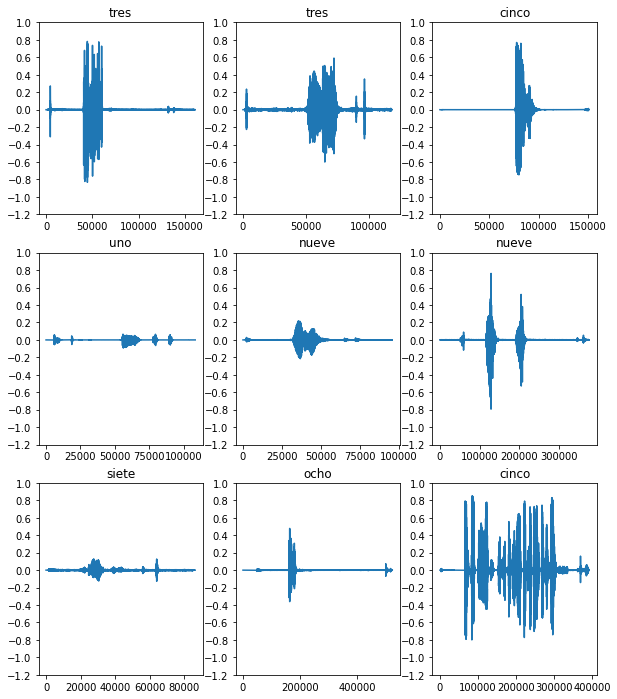

In [8]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

### Espectrogramas (Transformada de Fourier al espacio de frecuencias)

Ahora vamos a visualizar estos mismos datos pero en su espacio de frecuencias (no en el espacio de tiempo). Para esto se realiza la llamada Transformada de Fourier. La transformada de Fourier descompone una función en una suma continua (integral) de modos sinusoidales (con una frecuencia determinada). Si realizamos esta operación dividiendo la forma de onda en ventanas temporales, podemos ver qué frecuencias están más presentes en nuestros datos en cada ventana. Es decir, nos permite obtener espectrogramas en vez de formas de onda. 

La función $\texttt{get_spectrogram}$ recibe un tensor que representa la forma de onda de un archivo de audio y lo transforma a su espacio de frecuencias (espectrograma). Además, "rellena" los tensores obtenidos con ceros para que todos tengan el mismo tamaño. Esto último será necesario durante el entrenamiento.

In [9]:
def get_spectrogram(waveform):
    stfts = tf.signal.stft(waveform, frame_length=256, frame_step=128, fft_length=256)
    x = tf.math.pow(tf.abs(stfts), 0.5)


    pad_len = 1150
    paddings = tf.constant([[0, pad_len], [0, 0]])
    x = tf.pad(x, paddings, "CONSTANT")[:pad_len, :]
    return x

for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

Así como hicimos con las formas de onda, podemos graficar los mismos datos pero en su versión espectral:

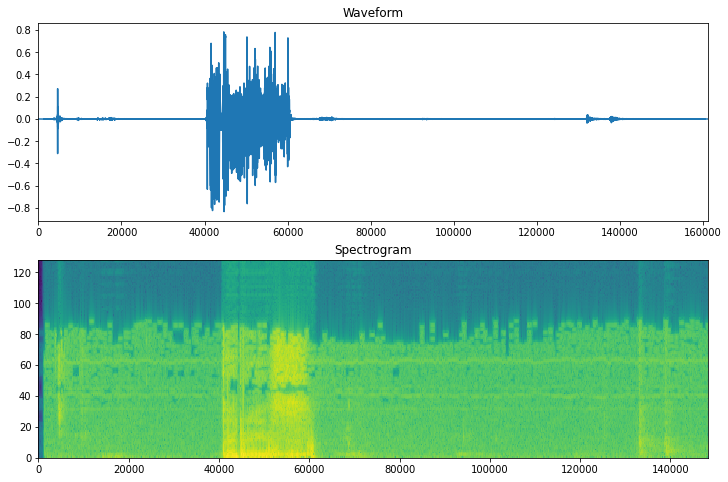

In [12]:
def plot_spectrogram(spectrogram, ax):
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, waveform.shape[0]])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

Estos espectrogramas son los que utilizaremos para entrenar nuestro modelo. 

¿Por qué los espectrogramas y no las formas de onda? Por una razón interesante: podemos pensar al espectrograma como una "foto" o imágen asociada a la señal sonora. Es decir, es una representación fotográfica de la onda de sonido. De esta manera, lo que antes era una señal de sonido, ahora es una foto. Las redes neuronales de clasificación de imágenes suelen ser del tipo convolucionales. Ahondaremos más adelante en lo que hace cada capa de este tipo de redes pero en síntesis, ya no tenemos un set de datos de sonido sino un set de datos de imágenes y cada imágen tiene asociada una etiqueta. ¡Como si estuviésemos clasificando fotos! 

De la misma manera que antes, construimos el objeto $\texttt{Dataset}$ de Tensorflow pero ahora para los espectrogramas.

In [14]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == keywords)
  return spectrogram, label_id

spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=tf.data.experimental.AUTOTUNE)

Análogamente, graficamos algunos espectrogramas con su etiqueta asociada. Vemos como ahora lo que tenemos son imágenes bidimensionales asociadas a cada palabra.

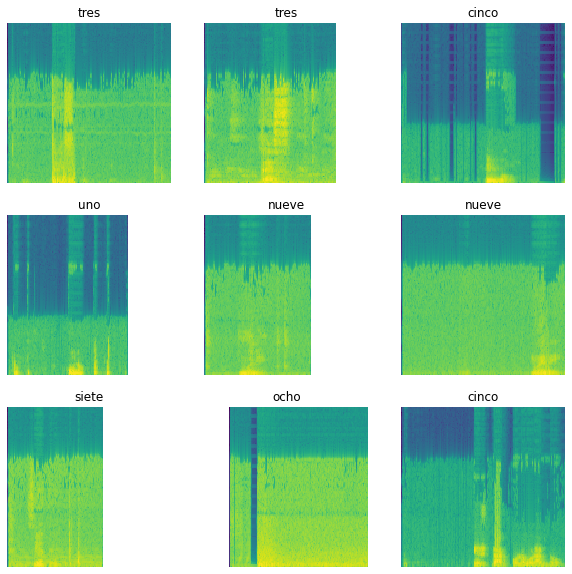

In [15]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(keywords[label_id.numpy()])
  ax.axis('off')

plt.show()

In [16]:
def preprocess_dataset(set):
  waveform_ds = create_waveform_dataset(set)
  spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  return spectrogram_ds

train_ds = spectrogram_ds
val_ds = preprocess_dataset(test_set)
test_ds = preprocess_dataset(val_set)

Una vez construido el dataset de Tensorflow, vamos a procesarlo en forma de $\textit{batches}$. Los batches son basicamente grupos de datos de entrenamineto que el algoritmo procesa y utiliza para realizar sus predicciones antes de actualizar sus parámetros. En general, el error asociado a un batch se calcula con algún tipo de promedio de los gradientes calculados para cada paso del batch. Separar el set de entrenamiento en batches suele optimizar el proceso de aprendizaje y el uso de recursos además de mejorar la performance.

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

### El modelo: CNN (Convolutional Neural Network)

Para la clasificación de imágenes, en el ámbito de las redes neuronales, un tipo muy utilizado son las Redes Neuronales Convolucionales. El módulo $\texttt{Keras.layers}$ trae implementados todos los tipos de capas necesarias para este tipo de arquitectura. Estas son: $\textit{Conv2D}$, $\textit{MaxPooling2d}$ y $\textit{DropOut}$. La primera y más importante es la capa que realiza las convoluciones. Este tipo de capa recibe una imágen, que en este contexto se representa con un tensor de rango 2 o matriz de números enteros y calcula la convolución en dos dimensiones entre la imágen y una serie de filtros. Los filtros son literalmente máscaras (matrices de 0 y 1) con diferentes formas. Estos filtros, recorren la imágen de izquierda a derecha y de arriba a abajo ralizando la convolución de cada sector de la imágen. De esta manera, la convolución con cada máscara va detectando qué lugares de la imágen pueden descomponerse en: lineas rectas con distinta orientación, círculos, cuadrados, etc...  

En la próxima secuencia de imágenes un ejemplo de juguete de como funciona la convolución y cuál es el resultado [3]:

!['title'](https://miro.medium.com/max/875/1*GuVRt1T9apScnlA6DLvbZA.png)
!['title'](https://miro.medium.com/max/875/1*gqDdVjiBDKbfiy73Dla4GQ.png)
!['title'](https://miro.medium.com/max/875/1*GBb3QETQiFwJFPpHtbHpAg.png)
!['title'](https://miro.medium.com/max/875/1*3xnBrDhMHSIVvcvKO6nhGw.png)
!['title'](https://miro.medium.com/max/875/1*KxJEaBsgYf4iD8WIiIUfEA.png)

Como vemos, cada filtro recorre la matriz de entrada (imagen inicial) y calcula para cada sector de la misma la convolución con el filtro. De esta manera, se obtiene una imágen más chica que es el resultado de hacer pasar la imagen por el filtro o máscara. Cada capa no tiene un solo filtro convolucional sino que suelen utilizarse 16, 32 o hasta 64 filtros que representan distintas formas y máscaras en la que descomponen la imagen. Finalmente se obtiene una cantidad de imágenes igual a la cantidad de filtros pero de menor tamaño. Es decir, hemos descompuesto la imágen en una serie de formas y figuras abstractas.

La siguiente capa típica es $\texttt{MaxPooling}$. Esta capa se utiliza simplemente para optimizar la performance del modelo. Lo que hace es agarrar la matriz saliente de la capa anterior y quedarse con el valor más alto en "ventanas" de la matriz de izquierda a derecha y de arriba abajo. Al igual que en la capa de convolución, se descompone la matriz entrante en otra de menor tamaño:

!['title'](https://miro.medium.com/max/875/1*Cx9Dl9Wu9a0Pazn79hbTlg.png)

Existen otros tipos de $\textit{pooling}$ con otros criterios en vez del máximo como el valor promedio del cuadrante.

Por último, tenemos el tipo de capa $\texttt{DropOut}$. Esta capa tiene una función meramente optimizadora y de mejora de performance. DropOut apaga aleatoriamente una fracción (cuya cantidad es un hiperparámetro a elegir) de las neuronas de la capa. Por ejemplo $\texttt{DropOut(0.1)}$ apaga aleatoriamente el 10% de las neuronas. Se ha encontrado que este es un muy buen método para prevenir el problema del $\textit{overfitting}$ pues evita que los datos siempre utilicen los mismos "caminos" dentro de la red y esta aprenda "de memoria" las respuestas.

Con estos tres tipos de capas, ya tenemos todo para armar nuestro modelo. Las tres capas suelen intercalarse a partir de la tríada convolución-pooling-dropout. Varias tríadas en secuencias descomponen lo suficiente la imágen inicial para que el modelo tenga todos los aspectos necesarios de la "foto" a disposición para "entender" como esta se relaciona con la etiqueta a predecir. 

Además, se agrega una capa de $\texttt{Resizing}$ para redimensionar la imágen de entrada a una cuadrada de $32x32$. Finalmente, siempre se agrega una capa del tipo $\texttt{Dense}$ del tamaño de la cantidad de etiquetas. De esta manera, cada neurona de la capa devuelve un valor numérico que luego mediante alguna normalización como $\texttt{Softmax}$ pueden interpretarse como una distribución de probabilidades de las etiquetas. Construimos el modelo con la clase $\texttt{Sequential}$:

In [37]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(keywords)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 4, activation='relu'),
    layers.Dropout(0.25),
    layers.Conv2D(64, 4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(128, 4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(128, 4, activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (1150, 129, 1)
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_10 (Resizing)       (None, 32, 32, 1)         0         
_________________________________________________________________
normalization_10 (Normalizat (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 29, 29, 32)        544       
_________________________________________________________________
dropout_49 (Dropout)         (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 26, 26, 64)        32832     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_50 (Dropout)     

Compilamos el modelo con un método de optimización -en este caso Adam, una implementación de Stochastic Gradient Descent-, una función de pérdida (Categorical Cross Entropy) y una métrica para hacer un seguimiento del aprendizaje. En este caso, y por tratarse de un modelo de clasificación categórica con un dataset bien distribuido, utilizaremos Accuracy.

In [38]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [39]:
EPOCHS = 100
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=10),
)

Epoch 1/100
210/210 [==============================] - 54s 243ms/step - loss: 2.0658 - accuracy: 0.2155 - val_loss: 0.7772 - val_accuracy: 0.7291
Epoch 2/100
210/210 [==============================] - 53s 233ms/step - loss: 1.0918 - accuracy: 0.6076 - val_loss: 0.4288 - val_accuracy: 0.8652
Epoch 3/100
210/210 [==============================] - 53s 239ms/step - loss: 0.7486 - accuracy: 0.7543 - val_loss: 0.3308 - val_accuracy: 0.8902
Epoch 4/100
210/210 [==============================] - 50s 232ms/step - loss: 0.5893 - accuracy: 0.8063 - val_loss: 0.2748 - val_accuracy: 0.9117
Epoch 5/100
210/210 [==============================] - 50s 234ms/step - loss: 0.5123 - accuracy: 0.8320 - val_loss: 0.2595 - val_accuracy: 0.9195
Epoch 6/100
210/210 [==============================] - 51s 234ms/step - loss: 0.4540 - accuracy: 0.8568 - val_loss: 0.2271 - val_accuracy: 0.9254
Epoch 7/100
210/210 [==============================] - 51s 235ms/step - loss: 0.4197 - accuracy: 0.8658 - val_loss: 0.2350 -

Guardamos el modelo en formato $\texttt{h5}$. Este es el formato en el que TensorFlow permite guardar los modelos secuenciales.

In [42]:
model.save('numbers.h5')

Con el modelo utilizado el método $\textit{Early stopping}$ detuvo el entrenamiento al pasar 27 epochs, cuando ya no encontró mejoría. A continuación se muestra el gráfico de la evolución de la función de costo sobre el set de entrenamiento y el de validación en función de los epochs. Vemos que el entrenamiento se detuvo luego de que los dos valores convergen y se empiezan a separar:

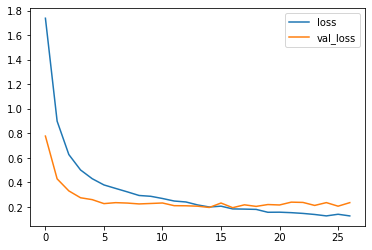

In [49]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

Se probó el modelo sobre el set de prueba, encontrando una exactitud del $94\%$:

In [40]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 94%


La matriz de confución puede darnos una idea de cómo se distribuye esta exactitud para las distintas etiquetas. Vemos que obtuvimos considerablemente buenos resultados:

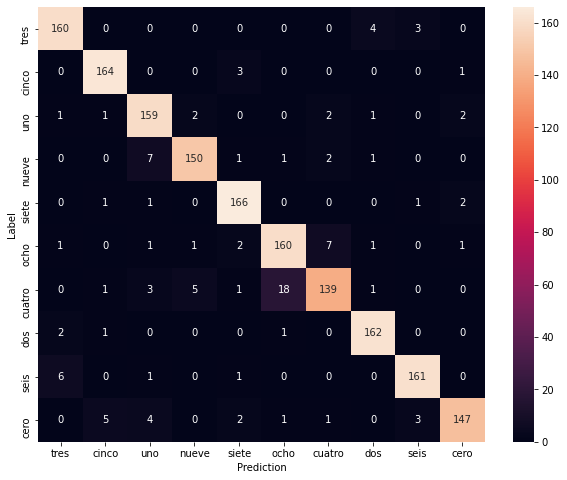

In [44]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=keywords, yticklabels=keywords, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

Vemos que buena parte de la inexactitud del modelo viene de la confusión producida al intentar predecir la palabra "cuatro", la cuál varias veces confunde con "ocho" y viceversa. Es esperable que sacando estas dos palabras del dataset, la performance mejore significativamente.

Con el modelo entrenado y guardado, podemos cargarlo para realizar predicciones y continuar probándolo. Para esto, agarramos un elemento al azar del set de prueba y calculamos las predicciones bajo su forma de distribución discreta de probabilidades (normalizadas con Softmax):

In [19]:
model = models.load_model('numbers.h5')

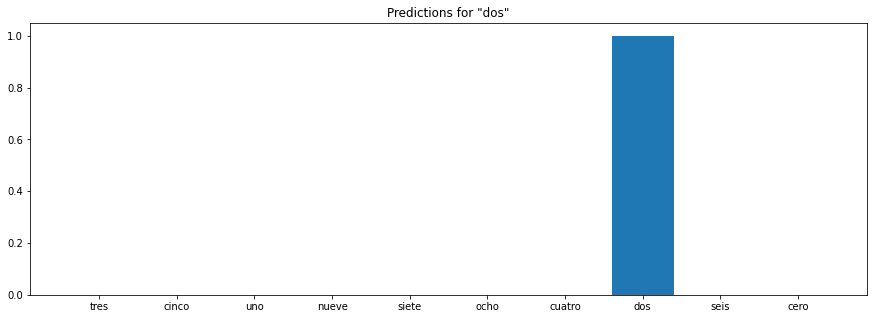

In [20]:
idx = np.random.randint(len(test_set))
test_sample = test_set[idx]

sample_ds = preprocess_dataset([test_sample])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.figure(figsize=(15,5))
  plt.bar(keywords, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{keywords[label[0]]}"')
  plt.show()

### Implementación en tiempo real

A continuación, implementamos el modelo entrenado para detectar y transcribir voz captada en tiempo real con la libería $\texttt{PyAudio}$.
En este caso se ha utilizado un ambiente de Anaconda con las librerías necesarias (recomendado). Para instalar PyAudio se ha utilizado directamente el archivo .whl descargado de [4]:

In [ ]:
!pip install PyAudio-0.2.11-cp37-cp37m-win_amd64.whl

Primero se configuran algunos parámetros necesarios como la tasa de muestreo de adquisición de datos de audio, el tiempo de grabación, la cantidad de canales, el dispositivo de adquisición (microfono), etc.

Luego, se crea una instancia de la clase  𝙿𝚢𝙰𝚞𝚍𝚒𝚘  y se abre un  Stream  durante el cuál ocurre la adquisición. El Stream se cierra y los datos, guardados en una objeto  𝚕𝚒𝚜𝚝  de Python, se procesan como objetos de TensorFlow para ser ingresados al modelo de predicción:

Importamos las librerías pertinentes:

In [21]:
import pyaudio
import wave

Definimos las variables necesarias. El parámetro $\texttt{INDEX_OF_CHOSEN_INPUT_DEVICE}$ dependerá del equipo del usuario y puede variar. Probar el correcto. Luego instanciamos la clase $\texttt{PyAudio}$. 

In [22]:
INDEX_OF_CHOSEN_INPUT_DEVICE = 1
FORMAT = pyaudio.paFloat32 # data type formate
CHANNELS = 1 # Adjust to your number of channels
RATE = 44100 # Sample Rate
CHUNK = 1024 # Block Size
RECORD_SECONDS = 1.3 # Record time
audio = pyaudio.PyAudio()
info = audio.get_host_api_info_by_index(0)
numdevices = info.get('deviceCount')

Abrimos el stream y definimos la lista donde se guardarán los datos adquiridos:

In [23]:
# start Recording
stream = audio.open(
                format=FORMAT, 
                channels=CHANNELS,
                rate=RATE, 
                input=True,
                input_device_index=INDEX_OF_CHOSEN_INPUT_DEVICE,
                frames_per_buffer=CHUNK)
frames = []

A continuación, definimos una función que se utilizará simplemente para reproducir una señal de alerta en la apertura y el cierre del tiempo de grabación:

In [29]:
def play_pip(file):
    chunk = 1024

    # open the file for reading.
    wf = wave.open(file, 'rb')

    # create an audio object
    p = pyaudio.PyAudio()

    # open stream based on the wave object which has been input.
    stream = p.open(format =
                    p.get_format_from_width(wf.getsampwidth()),
                    channels = wf.getnchannels(),
                    rate = wf.getframerate(),
                    output = True)

    # read data (based on the chunk size)
    data = wf.readframes(chunk)

    # play stream (looping from beginning of file to the end)
    while data != b'':
        # writing to the stream is what *actually* plays the sound.
        stream.write(data)
        data = wf.readframes(chunk)

    # cleanup stuff.
    stream.close()    
    p.terminate()
    return 

Tener en cuenta que para utilizarla será necesario tener preparados dos archivos en formato ".wav". En mi caso los he guardado en el directorio "sounds" dentro del path principal como "sounds/open.wav" y "sounds/close.wav".

Comenzamos la grabación. Después del tono diga algún número del uno al nueve en idioma español. Tener en cuenta que el modelo no tiene una exactitud del $100\%$ y la predicción puede ser equivocada.

In [25]:
# Record for RECORD_SECONDS
print ('Después del tono diga un número del uno al nueve...')
play_pip('sounds/open.wav')
for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)
play_pip('sounds/close.wav')
print ("Listo...")

# Stop Recording
stream.stop_stream()
stream.close()
audio.terminate()

Después del tono diga un número del uno al nueve...
Listo...


Luego, procesamos los datos con TensorFlow y los preparamos para la predicción del modelo:

In [26]:
audio = tf.convert_to_tensor(b''.join(frames))
audio = tf.io.decode_raw(audio,float)
#audio = tf.reshape(audio,[audio.shape[0],1])
audio = tf.where(tf.math.is_nan(audio), tf.zeros_like(audio), audio)
#audio = tf.squeeze(audio, axis=-1)
stfts = tf.signal.stft(audio, frame_length=256, frame_step=128, fft_length=256)
x = tf.math.pow(tf.abs(stfts), 0.5)
pad_len = 1150
paddings = tf.constant([[0, pad_len], [0, 0]])
x = tf.pad(x, paddings, "CONSTANT")[:pad_len, :]
x =  tf.reshape(x,[1,x.shape[0],x.shape[1],1])

Por último, con los datos adquiridos y procesados, realizamos la predicción:

In [27]:
prediction_idx = np.argmax(model.predict(x), axis=-1)[0]
prediction = keywords[prediction_idx]
print('¿Usted ha dicho "{}"?'.format(prediction.title()))

¿Usted ha dicho "Uno"?


## Referencias

[1] $\textit{https://commonvoice.mozilla.org/es/datasets}$

[2] $\textit{https://www.tensorflow.org/tutorials/audio/simple_audio}$

[3] $\textit{https://towardsdatascience.com/a-beginners-guide-to-convolutional-neural-networks-cnns-14649dbddce8}$

[4] $\textit{https://people.csail.mit.edu/hubert/pyaudio/packages/}$